# training models on 6.dataset with nested cross validation

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict,cross_validate,StratifiedKFold

from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from scipy.interpolate import interp1d
from sklearn.utils import compute_sample_weight

from sklearn.metrics import roc_curve,make_scorer,average_precision_score, matthews_corrcoef,precision_recall_curve,classification_report \
,accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score,confusion_matrix, auc

In [3]:
class PerformanceMetrics:
    def __init__(self):
        self.accuracy_scores = []
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []
        self.balanced_accuracy_scores = []
        self.roc_auc_scores = []
        self.average_precision_scores = []
        self.mcc_scores = []

def calculate_performance_metrics(y_true, y_pred, y_pred_prob):
    metrics = PerformanceMetrics()

    metrics.accuracy_scores.append(accuracy_score(y_true, y_pred))
    metrics.precision_scores.append(precision_score(y_true, y_pred, average='macro',zero_division=0))
    metrics.recall_scores.append(recall_score(y_true, y_pred, average='macro'))
    metrics.f1_scores.append(f1_score(y_true, y_pred, average='macro'))
    metrics.balanced_accuracy_scores.append(balanced_accuracy_score(y_true, y_pred))
    metrics.roc_auc_scores.append(roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='macro'))
    metrics.average_precision_scores.append(average_precision_score(y_true, y_pred_prob, average='macro'))
    metrics.mcc_scores.append(matthews_corrcoef(y_true, y_pred))
    
    return metrics


def display_mean_metrics(metrics_list):
    # Calculate the overall mean performance metrics across all folds
    mean_accuracy = np.mean([metrics.accuracy_scores for metrics in metrics_list])
    mean_precision = np.mean([metrics.precision_scores for metrics in metrics_list])
    mean_recall = np.mean([metrics.recall_scores for metrics in metrics_list])
    mean_f1 = np.mean([metrics.f1_scores for metrics in metrics_list])
    mean_balanced_accuracy = np.mean([metrics.balanced_accuracy_scores for metrics in metrics_list])
    mean_roc_auc = np.mean([metrics.roc_auc_scores for metrics in metrics_list])
    mean_average_precision = np.mean([metrics.average_precision_scores for metrics in metrics_list])
    mean_mcc = np.mean([metrics.mcc_scores for metrics in metrics_list])

    print("Overall Mean Accuracy:", mean_accuracy)
    print("Overall Mean Precision:", mean_precision)
    print("Overall Mean Recall:", mean_recall)
    print("Overall Mean F1-score:", mean_f1)
    print("Overall Mean Balanced Accuracy:", mean_balanced_accuracy)
    print("Overall Mean ROC-AUC:", mean_roc_auc)
    print("Overall Mean Average Precision:", mean_average_precision)
    print("Overall Mean MCC:", mean_mcc)

In [4]:
def plot_average_roc_curve(fprs, tprs):
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([interp1d(fpr, tpr, kind='linear')(mean_fpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# load the data and prepare it for training

In [5]:
df = pd.read_csv('dataset5/dataset6.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [6]:
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'])

label_encoder = LabelEncoder()
for i in ["gender", "hypertension", "heart_disease", "ever_married", "Residence_type"]:
    df[i] = label_encoder.fit_transform(df[i])
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,False,True,False,False,False,True,False,False
1,1,80.0,0,1,1,0,105.92,32.5,1,False,True,False,False,False,False,True,False
2,0,49.0,0,0,1,1,171.23,34.4,1,False,True,False,False,False,False,False,True
3,0,79.0,1,0,1,0,174.12,24.0,1,False,False,True,False,False,False,True,False
4,1,81.0,0,0,1,1,186.21,29.0,1,False,True,False,False,False,True,False,False


In [7]:
numerical_features = df[["age", "avg_glucose_level", "bmi"]]
scaler = StandardScaler()
scaler.fit(numerical_features)
numerical_features = scaler.transform(numerical_features)
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,False,True,False,False,False,True,False,False
1,1,80.0,0,1,1,0,105.92,32.5,1,False,True,False,False,False,False,True,False
2,0,49.0,0,0,1,1,171.23,34.4,1,False,True,False,False,False,False,False,True
3,0,79.0,1,0,1,0,174.12,24.0,1,False,False,True,False,False,False,True,False
4,1,81.0,0,0,1,1,186.21,29.0,1,False,True,False,False,False,True,False,False


In [8]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

# Convert the features and labels to numpy arrays
Xarr = np.array(X)
yarr = np.array(y)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Training the models

In [12]:
f1_scorer = make_scorer(f1_score)

## SGDClassifier

In [9]:
sgd_clf = SGDClassifier(class_weight="balanced",random_state=42)

Best Parameters: {'alpha': 0.01, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elasticnet', 'power_t': 0.25}
Best Parameters: {'alpha': 0.001, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2', 'power_t': 0.25}
Best Parameters: {'alpha': 0.01, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'power_t': 0.25}
Best Parameters: {'alpha': 0.001, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'power_t': 0.25}
Best Parameters: {'alpha': 0.01, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elasticnet', 'power_t': 0.25}
Best Parameters: {'alpha': 0.1, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l1', 'power_t': 0.25}
Best Parameters: {'alpha': 0.1, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2', 'power_t': 0.25}
Best Parameters: {'alpha': 0.001, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'elasticnet', 'power_t': 0.25}
Best Parameters: {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l1', 'power_t': 0.

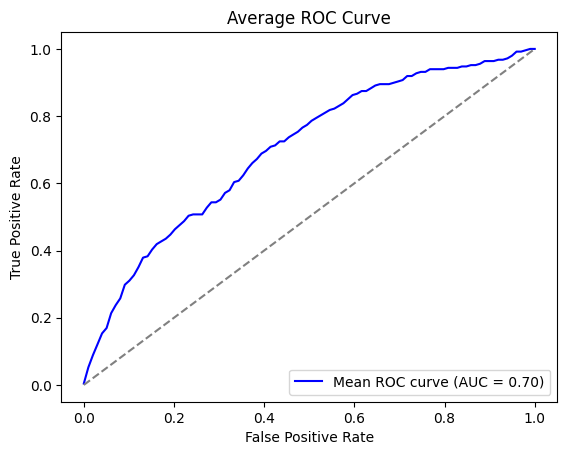

In [15]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'loss': ['hinge', 'squared_hinge', 'modified_huber', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'max_iter': [1000, 2000, 3000],  # Maximum number of iterations for optimization
   # 'tol': [1e-3, 1e-4, 1e-5],  # Tolerance for stopping criteria
   # 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
   # 'eta0': [0.01, 0.1, 1.0],  # Initial learning rate
    'power_t': [0.25, 0.5, 0.75],  # Power for the inverse scaling learning rate
}

# Nested cross-validation
metrics_list = []
fprs, tprs = [], []
for fold_num, (outer_train_index, outer_test_index) in enumerate(outer_cv.split(X, y)):
    X_outer_train, X_outer_test = Xarr[outer_train_index], Xarr[outer_test_index]
    y_outer_train, y_outer_test = yarr[outer_train_index], yarr[outer_test_index]

    grid_search = GridSearchCV(estimator=sgd_clf, param_grid=param_grid, cv=inner_cv, scoring=f1_scorer,n_jobs = -1,refit = True)
    grid_search.fit(X_outer_train, y_outer_train)

    # Get the best model from the inner cross-validation
    best_model = grid_search.best_estimator_
    y_pred_prob = cross_val_predict(best_model, X_outer_test, y_outer_test, cv=3,method="decision_function")
    y_pred = best_model.predict(X_outer_test)
    best_params = grid_search.best_params_
    metrics = calculate_performance_metrics(y_outer_test, y_pred, y_pred_prob)
    metrics_list.append(metrics)

    fpr, tpr, _ = roc_curve(y_outer_test, y_pred_prob)
    fprs.append(fpr)
    tprs.append(tpr)
    
    print(f"Best Param for fold {fold_num + 1}" ," : ", best_params)

print("\nSGDClassifier:\n")
display_mean_metrics(metrics_list)
plot_average_roc_curve(fprs, tprs)



## RandomForestClassifier

In [17]:
forest_clf = RandomForestClassifier(class_weight="balanced",random_state=42)

Best param for fold 1 :  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best param for fold 2 :  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best param for fold 3 :  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best param for fold 4 :  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best param for fold 5 :  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best param for fold 6 :  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best param for fold 7 :  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best param for fold 8 :  {'criterion': 'gini', 'max_dept

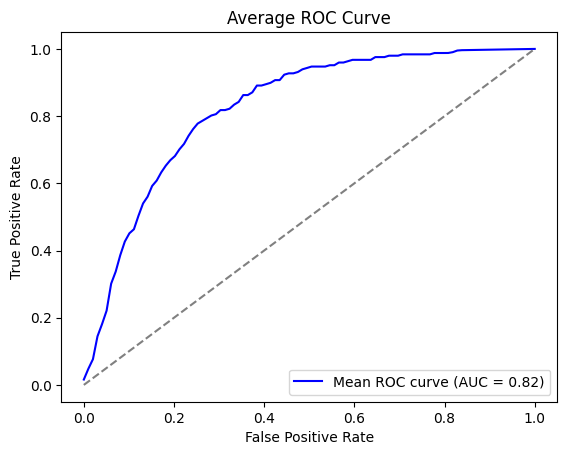

In [19]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree. None means unlimited depth.
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    #'max_features': ['auto', 'sqrt', 'log2',None],  # Number of features to consider at each split
}

# Nested cross-validation
metrics_list = []
fprs, tprs = [], []
for fold_num, (outer_train_index, outer_test_index) in enumerate(outer_cv.split(X, y)):
    X_outer_train, X_outer_test = Xarr[outer_train_index], Xarr[outer_test_index]
    y_outer_train, y_outer_test = yarr[outer_train_index], yarr[outer_test_index]

    grid_search = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv=inner_cv, scoring=f1_scorer,n_jobs = -1,refit = True)
    grid_search.fit(X_outer_train, y_outer_train)
    # Get the best model from the inner cross-validation
    best_model = grid_search.best_estimator_

    y_pred_prob = best_model.predict_proba(X_outer_test)[:, 1]
    y_pred = best_model.predict(X_outer_test)
    best_params = grid_search.best_params_
    metrics = calculate_performance_metrics(y_outer_test, y_pred, y_pred_prob)
    metrics_list.append(metrics)

    fpr, tpr, _ = roc_curve(y_outer_test, y_pred_prob)
    fprs.append(fpr)
    tprs.append(tpr)
    
    print(f"Best param for fold {fold_num + 1} : ", best_params)

print("\nRandomForestClassifier:\n")
display_mean_metrics(metrics_list)
plot_average_roc_curve(fprs, tprs)



## Gradient Boosting

In [10]:
gb_clf = GradientBoostingClassifier()

Best param for fold 1 :  {'learning_rate': 0.2, 'n_estimators': 50}
Best param for fold 2 :  {'learning_rate': 0.2, 'n_estimators': 50}
Best param for fold 3 :  {'learning_rate': 0.2, 'n_estimators': 100}
Best param for fold 4 :  {'learning_rate': 0.2, 'n_estimators': 50}
Best param for fold 5 :  {'learning_rate': 0.1, 'n_estimators': 200}
Best param for fold 6 :  {'learning_rate': 0.1, 'n_estimators': 50}
Best param for fold 7 :  {'learning_rate': 0.1, 'n_estimators': 100}
Best param for fold 8 :  {'learning_rate': 0.1, 'n_estimators': 100}
Best param for fold 9 :  {'learning_rate': 0.2, 'n_estimators': 200}
Best param for fold 10 :  {'learning_rate': 0.1, 'n_estimators': 100}

Gradient Boosting:

Overall Mean Accuracy: 0.7926121318943107
Overall Mean Precision: 0.5624193347591926
Overall Mean Recall: 0.7262013831277152
Overall Mean F1-score: 0.5586368376072669
Overall Mean Balanced Accuracy: 0.7262013831277152
Overall Mean ROC-AUC: 0.8135062124036955
Overall Mean Average Precision: 0

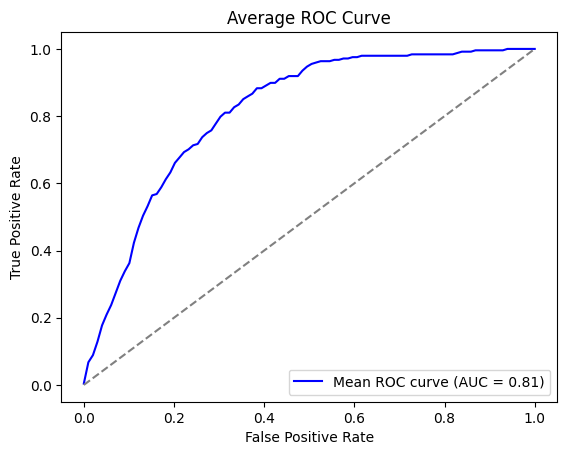

In [14]:

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate for each boosting stage
    'n_estimators': [50, 100, 200],  # Number of boosting stages (trees)
    #'max_depth': [3, 4, 5],  # Maximum depth of the individual trees
    #'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    #'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    #'subsample': [0.8, 1.0],  # Fraction of samples used for fitting the trees
    #'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}

# Nested cross-validation
metrics_list = []
fprs, tprs = [], []
for fold_num, (outer_train_index, outer_test_index) in enumerate(outer_cv.split(X, y)):
    X_outer_train, X_outer_test = Xarr[outer_train_index], Xarr[outer_test_index]
    y_outer_train, y_outer_test = yarr[outer_train_index], yarr[outer_test_index]

    # CALCULATING THE CLASS WEIGHT SO THE DATA IS BALANCED
    unique_classes = np.unique(y_outer_train)
    class_counts = np.bincount(y_outer_train)
    # Calculate the frequency of each class in the training data
    class_frequencies = {class_label: count / len(y_outer_train) for class_label, count in zip(unique_classes, class_counts)}
    # Calculate the balanced sample weights for each sample
    balanced_sample_weights = np.array([1.0 / class_frequencies[class_label] for class_label in y_outer_train])

    grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=inner_cv, scoring=f1_scorer,refit = True)
    grid_search.fit(X_outer_train, y_outer_train,sample_weight =balanced_sample_weights)
    best_model = grid_search.best_estimator_

    y_pred_prob = best_model.predict_proba(X_outer_test)[:, 1]
    y_pred = best_model.predict(X_outer_test)
    best_params = grid_search.best_params_
    metrics = calculate_performance_metrics(y_outer_test, y_pred, y_pred_prob)
    metrics_list.append(metrics)

    fpr, tpr, _ = roc_curve(y_outer_test, y_pred_prob)
    fprs.append(fpr)
    tprs.append(tpr)
    
    print(f"Best param for fold {fold_num + 1} : ", best_params)

print("\nGradient Boosting:\n")
display_mean_metrics(metrics_list)
plot_average_roc_curve(fprs, tprs)

## Gaussian distribution Clasifier

In [16]:
gnb_clf = GaussianNB()


Gaussian distribution Clasifier:

Overall Mean Accuracy: 0.8104751672018736
Overall Mean Precision: 0.555093077517886
Overall Mean Recall: 0.680505836254806
Overall Mean F1-score: 0.5560927211827653
Overall Mean Balanced Accuracy: 0.680505836254806
Overall Mean ROC-AUC: 0.8015361333380909
Overall Mean Average Precision: 0.1777943055396401
Overall Mean MCC: 0.19931297652276275


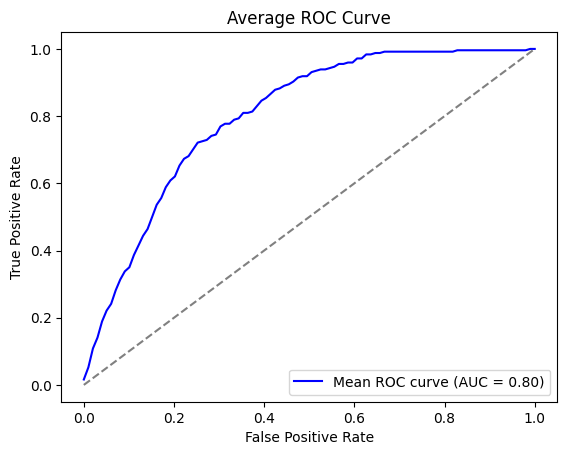

In [19]:
param_grid = {}

metrics_list = []
fprs, tprs = [], []
for fold_num, (outer_train_index, outer_test_index) in enumerate(outer_cv.split(X, y)):
    X_outer_train, X_outer_test = Xarr[outer_train_index], Xarr[outer_test_index]
    y_outer_train, y_outer_test = yarr[outer_train_index], yarr[outer_test_index]

    grid_search = GridSearchCV(estimator=gnb_clf, param_grid=param_grid, cv=inner_cv, scoring=f1_scorer,n_jobs = -1,refit = True)
    grid_search.fit(X_outer_train, y_outer_train)
    best_model = grid_search.best_estimator_

    y_pred_prob = best_model.predict_proba(X_outer_test)[:, 1]
    y_pred = best_model.predict(X_outer_test)
    metrics = calculate_performance_metrics(y_outer_test, y_pred, y_pred_prob)
    metrics_list.append(metrics)

    fpr, tpr, _ = roc_curve(y_outer_test, y_pred_prob)
    fprs.append(fpr)
    tprs.append(tpr)
    

print("\nGaussian distribution Clasifier:\n")
display_mean_metrics(metrics_list)
plot_average_roc_curve(fprs, tprs)